<a href="https://colab.research.google.com/github/AmirHossein-STP/power-market-simulation/blob/main/Power_Market_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
class Producer:
    def __init__(self, name, nominal_capacity, day_of_construction = 0, construction_delay = 0):
        self.name = name
        self.nominal_capacity = nominal_capacity
        self.cost_function_coefs = [(rng.standard_normal()+1)*1e3,(rng.standard_normal()/200+1)*6,(rng.standard_normal()/10+1)*9e-4,(rng.standard_normal()/10+1)*9e-8]
        self.over_capacity_coef = 1.1
        self.day_of_construction = day_of_construction
        self.construction_delay = construction_delay

    def true_capacity(self, day):
        if ((day - self.day_of_construction)<self.construction_delay):
          capacity = 0
          return capacity

        capacity = self.nominal_capacity
        if (day%365)>274:
          capacity*=0.9 #cause in winter gas shortage is likely

        day_of_start = self.day_of_construction + self.construction_delay
        capacity *= (1-(day-day_of_start)/1000)
        if capacity < 0:
          capacity = 0

        return capacity

    def cost_function(self, supply, day):
        A = self.cost_function_coefs[0]
        B = self.cost_function_coefs[1]
        C = self.cost_function_coefs[2]
        D = self.cost_function_coefs[3]
        p_normal = A + B * supply + C * supply**2 + D * supply**3

        if(supply<=self.true_capacity(day)):
          return p_normal
        else:
          return p_normal+1.02**(supply-self.true_capacity(day))

    def marginal_cost(self, supply, day):
        A = self.cost_function_coefs[0]
        B = self.cost_function_coefs[1]
        C = self.cost_function_coefs[2]
        D = self.cost_function_coefs[3]
        p_normal = B + 2 * C * supply + 3 * D * supply**2
    def avrg_variable_cost(self, supply, day):
        A = self.cost_function_coefs[0]
        B = self.cost_function_coefs[1]
        C = self.cost_function_coefs[2]
        D = self.cost_function_coefs[3]
        p_normal = B + C * supply + D * supply**2

    # def produce(self, demand, day):
    #     supply = min(self.true_capacity(day)*self.over_capacity_coef, demand)
    #     cost = self.cost_function(supply)
    #     return supply, cost

    # def adjust_capacity(self, price):
    #     # Increase capacity if price is high, decrease if low
    #     if price > 15:
    #         self.capacity *= 1.1  # Increase capacity by 10%
    #     elif price < 10:
    #         self.capacity *= 0.9  # Decrease capacity by 10%
    #     self.capacity = max(50, self.capacity)  # Ensure a minimum capacity


class Consumer:
    def __init__(self, name, demand):
        self.name = name
        self.demand = demand

    def demand_at_hour(self, hour):
        # Demand varies based on the hour of the day
        if 6 <= hour < 12:
            return self.demand*(rng.standard_normal()*5+45)/60   # Morning peak
        elif 12 <= hour < 18:
            return self.demand*(rng.standard_normal()*4+30)/60  # Afternoon low
        elif 18 <= hour < 22:
            return self.demand*(rng.standard_normal()*4+60)/60  # Evening peak
        else:
            return self.demand*(rng.standard_normal()*3+15)/60  # Night low

In [3]:
class Market:
    def __init__(self):
        self.producers = []
        self.consumers = []
        self.supply_curve = []
        self.supply_step = 300

    def add_producer(self, producer):
        self.producers.append(producer)

    def add_consumer(self, consumer):
        self.consumers.append(consumer)

    def aggregate_supply(self, day):
        # Create aggregate supply curve based on marginal cost
        self.supply_curve = []
        for producer in self.producers:
            for supply in range(self.supply_step, int(producer.true_capacity(day)*producer.over_capacity_coef) + self.supply_step, self.supply_step):
                marginal_cost = (producer.cost_function(supply, day) - producer.cost_function(supply-self.supply_step, day))/self.supply_step
                price = marginal_cost
                self.supply_curve.append((producer, price))
        self.supply_curve.sort(key=lambda x: x[1])  # Sort by marginal cost to create the supply curve

    def aggregate_demand(self, hour):
        self.total_demand = sum(consumer.demand_at_hour(hour) for consumer in self.consumers)
        return self.total_demand

    def match_supply_and_demand(self):
        supply_details = []
        remaining_demand = self.total_demand

        final_price = 10
        # Allocate supply based on the aggregate supply curve
        for producer, price in self.supply_curve:
            if remaining_demand <= 0:
                break
            allocated_supply = min(self.supply_step, remaining_demand)
            remaining_demand -= allocated_supply
            final_price = price
            # supply_details.append((producer.name, allocated_supply, price))

        # Calculate average price to adjust producer capacity
        # avg_price = total_cost / total_demand if total_demand > 0 else 0
        # for producer in self.producers:
        #     producer.adjust_capacity(avg_price)

        return remaining_demand, final_price

    def plot_supply_curve(self):
        producer_colors = {}
        quantities = []
        costs = []
        colors = []

        unique_categories = list(set(self.producers))
        category_colors = {category: plt.cm.tab10(i) for i, category in enumerate(unique_categories)}

        i=1
        for producer, price in self.supply_curve:
            i+=1
            costs.append(price)
            quantities.append(self.supply_step*i)
            colors.append(category_colors[producer])

        plt.scatter(quantities, costs, c=colors, s=1)

        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cat.name)
           for cat, color in category_colors.items()]
        plt.legend(handles=handles, title='Producers')
        plt.xlabel("Quantity Supplied")
        plt.ylabel("Marginal Cost")
        plt.title("Aggregate Supply Curve")

        plt.grid(True)
        plt.show()
    def capacity(self,day):
      return sum(producer.true_capacity(day) for producer in self.producers)


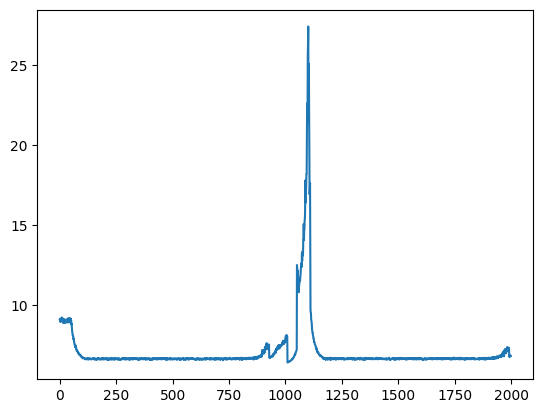

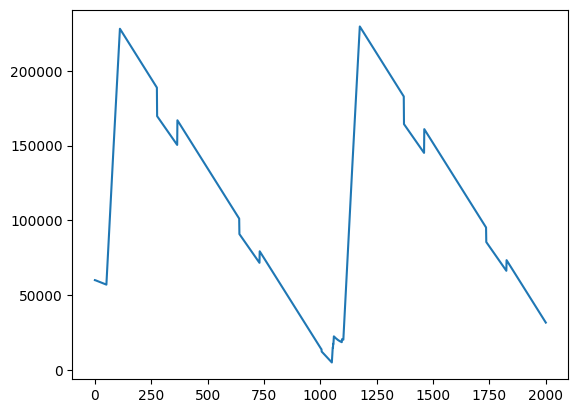

In [4]:
market = Market()
capacity_payment = 7
initial_producer_count = 20
for i in range(1):
  market.add_consumer(Consumer("Consumer",50000))
for i in range(1, initial_producer_count+1):
  market.add_producer(Producer("Producer " + str(i), nominal_capacity=3000))
# market.aggregate_supply(day=0)
# market.plot_supply_curve()
prices = []
market_capacity = [market.capacity(0)]
avrg_daily_price = 0
for day in range(2000):
    if(avrg_daily_price+capacity_payment>15):
        market.add_producer(Producer("Producer " + str(len(market.producers)+1), nominal_capacity=3000,day_of_construction=day,construction_delay=50))
        initial_producer_count += 1

    market.aggregate_supply(day=day)
    # market.plot_supply_curve()

    sum_price = 0
    total_sum_price = 0
    # Simulate market over 24 hours
    for hour in range(24):
        # print(f"\nHour {hour}:")
        total_demand = market.aggregate_demand(hour)
        remaining_demand, final_price = market.match_supply_and_demand()

        # if remaining_demand > 0:
        #     print(f"Day {day}, Hour {hour}: Market could not meet the total demand.")
        #     print(f"Total Demand: {total_demand:.1f}")
        #     print(f"Remaining Demand: {remaining_demand}")
        # else:
        #     print(f"Hour {hour}: Market successfully met the total demand.")
        #     print(f"Total Demand: {total_demand:.1f}")

        # print(f"Final Price: {final_price:.3f}")
        # print("\n")
        sum_price += final_price
        total_sum_price += total_demand*final_price

    avrg_daily_price = sum_price/24
    # print(avrg_daily_price)
    prices.append(avrg_daily_price)
    market_capacity.append(market.capacity(day))



# market.plot_supply_curve()
# plt.show()
plt.plot(prices)
plt.show()
plt.plot(market_capacity)
plt.show()

In [5]:
print(market_capacity)

[60000.0, 60000.0, 59940.0, 59880.0, 59820.0, 59760.0, 59700.0, 59640.0, 59580.0, 59520.0, 59460.0, 59400.0, 59340.0, 59280.0, 59220.0, 59160.0, 59100.0, 59040.0, 58980.0, 58920.0, 58860.0, 58800.0, 58740.0, 58680.0, 58620.0, 58560.0, 58500.0, 58440.0, 58380.0, 58320.0, 58260.0, 58200.0, 58140.0, 58080.0, 58020.0, 57960.0, 57900.0, 57840.0, 57780.0, 57720.0, 57660.0, 57600.0, 57540.0, 57480.0, 57420.0, 57360.0, 57300.0, 57240.0, 57180.0, 57120.0, 57060.0, 57000.0, 59940.0, 62877.0, 65811.0, 68742.0, 71670.0, 74595.0, 77517.0, 80436.0, 83352.0, 86265.0, 89175.0, 92082.0, 94986.0, 97887.0, 100785.0, 103680.0, 106572.0, 109461.0, 112347.0, 115230.0, 118110.0, 120987.0, 123861.0, 126732.0, 129600.0, 132465.0, 135327.0, 138186.0, 141042.0, 143895.0, 146745.0, 149592.0, 152436.0, 155277.0, 158115.0, 160950.0, 163782.0, 166611.0, 169437.0, 172260.0, 175080.0, 177897.0, 180711.0, 183522.0, 186330.0, 189135.0, 191937.0, 194736.0, 197532.0, 200325.0, 203115.0, 205902.0, 208686.0, 211467.0, 21424

In [ ]:
# TODOS: calculate average total cost and then instead of compare price with a constant, compare it with atc
# TOSOS: make producer spawning random with the probabilty of diffrence of prices